In [53]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


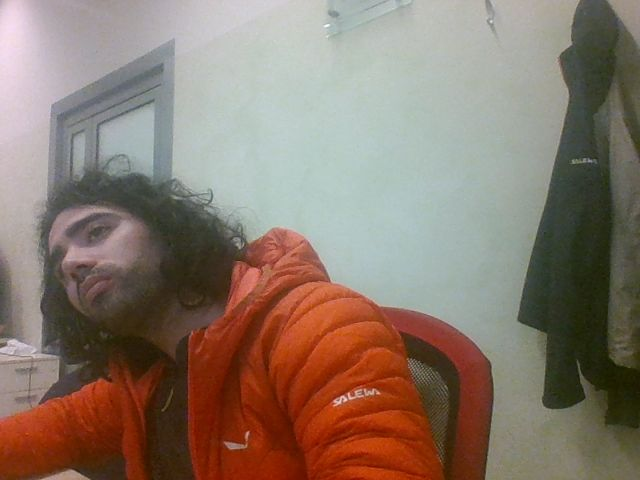

In [54]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!pip install ultralytics

In [ ]:
# https://alimustoofaa.medium.com/yolov8-pose-estimation-and-pose-keypoint-classification-using-neural-net-pytorch-98469b924525

In [55]:
from pydantic import BaseModel

class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16



In [56]:
def get_rectangle_area(img):
    img_draw = img.copy()

    # Get image height and width
    height, width = img.shape[:2]

    # Calculate center coordinates for the rectangle
    center_x = int(width / 2)
    center_y = int(height / 2)

    # Define rectangle dimensions (adjust width and height as needed)
    rectangle_width = 200
    rectangle_height = 200

    # Top-left corner coordinates of the rectangle
    top_left_x = center_x - int(rectangle_width / 2)
    top_left_y = center_y - int(rectangle_height / 2)

    # Bottom-right corner coordinates (calculated automatically)
    bottom_right_x = top_left_x + rectangle_width
    bottom_right_y = top_left_y + rectangle_height

    # Define rectangle color (BGR format)
    color = (0, 255, 0)  # Green color

    # Draw the rectangle on the image
    cv2.rectangle(img_draw, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, thickness=2)
    return img_draw, [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

def is_point_inside_rectangle(x, y, x1, y1, width, height):
  """
  Checks if a point (x, y) is inside a rectangle defined by top-left corner (x1, y1) and dimensions (width, height).

  Args:
      x: X-coordinate of the point.
      y: Y-coordinate of the point.
      x1: X-coordinate of the top-left corner of the rectangle.
      y1: Y-coordinate of the top-left corner of the rectangle.
      width: Width of the rectangle.
      height: Height of the rectangle.

  Returns:
      True if the point is inside the rectangle, False otherwise.
  """

  # Check if the point is within the horizontal and vertical boundaries of the rectangle.
  return x1 <= x <= x1 + width and y1 <= y <= y1 + height

In [57]:
from ultralytics import YOLO
import cv2

# example
get_keypoint = GetKeypoint()

# Load a pretrained YOLOv8 pose model
model = YOLO('yolov8n-pose.pt')

# Run inference on an image
img = cv2.imread("photo.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Get a rectangle inside the image
img_draw, [xr1,yr1,xr2,yr2] = get_rectangle_area(img)

results = model('photo.jpg')

keypoint = results[0].keypoints.xyn.cpu().numpy()

# Iterate over the images
for result in results:
    all_keypoints = result.keypoints.xy.cpu().numpy()
    for i in range(0, len(all_keypoints)):
        score = result.boxes[i].conf.cpu().numpy().item()
        id = int( result.boxes[i].cls.cpu().numpy().item() )
        name = result.names[id]

        # Check if there is a person and the eye are inside the area!
        if score >0.8 and name=="person":
            box_xyxy = result.boxes[i].xyxy.cpu().numpy()[0]
            x1, y1, x2, y2 = box_xyxy.astype(int)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
            cv2.putText(img, f"{name}: {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            keypoints = all_keypoints[i]
            nose_x,           nose_y = keypoints[get_keypoint.NOSE]
            left_eye_x,       left_eye_y = keypoints[get_keypoint.LEFT_EYE]
            right_eye_x,      right_eye_y = keypoints[get_keypoint.RIGHT_EYE]
            left_ear_x,       left_ear_y = keypoints[get_keypoint.LEFT_EAR]
            right_ear_x,      right_ear_y = keypoints[get_keypoint.RIGHT_EAR]
            left_shoulder_x,  left_shoulder_y = keypoints[get_keypoint.LEFT_SHOULDER]
            right_shoulder_x, right_shoulder_y = keypoints[get_keypoint.RIGHT_SHOULDER]
            left_elbow_x,     left_elbow_y = keypoints[get_keypoint.LEFT_ELBOW]
            right_elbow_x,    right_elbow_y = keypoints[get_keypoint.RIGHT_ELBOW]
            left_wrist_x,     left_wrist_y = keypoints[get_keypoint.LEFT_WRIST]
            right_wrist_x,    right_wrist_y = keypoints[get_keypoint.RIGHT_WRIST]
            left_hip_x,       left_hip_y = keypoints[get_keypoint.LEFT_HIP]
            right_hip_x,      right_hip_y = keypoints[get_keypoint.RIGHT_HIP]
            left_knee_x,      left_knee_y = keypoints[get_keypoint.LEFT_KNEE]
            right_knee_x,     right_knee_y = keypoints[get_keypoint.RIGHT_KNEE]
            left_ankle_x,     left_ankle_y = keypoints[get_keypoint.LEFT_ANKLE]
            right_ankle_x,    right_ankle_y = keypoints[get_keypoint.RIGHT_ANKLE]

            cv2.circle(img, (int(nose_x), int(nose_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_eye_x), int(left_eye_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_eye_x), int(right_eye_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_ear_x), int(left_ear_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_ear_x), int(right_ear_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_shoulder_x), int(left_shoulder_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_shoulder_x), int(right_shoulder_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_elbow_x), int(left_elbow_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_elbow_x), int(right_elbow_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_wrist_x), int(left_wrist_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_wrist_x), int(right_wrist_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_hip_x), int(left_hip_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_hip_x), int(right_hip_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_knee_x), int(left_knee_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_knee_x), int(right_knee_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_ankle_x), int(left_ankle_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_ankle_x), int(right_ankle_y)), 5, (0, 0, 255), -1)

            left_inside = is_point_inside_rectangle(left_eye_x, left_eye_y, xr1,yr1, xr2-xr1,yr2-yr1)
            right_inside = is_point_inside_rectangle(right_eye_x, right_eye_y, xr1,yr1, xr2-xr1,yr2-yr1)

            if left_inside and right_inside:
                print("Concentrated")
            else:
                print("Focus Please!")




image 1/1 /content/photo.jpg: 480x640 2 persons, 203.6ms
Speed: 2.2ms preprocess, 203.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [158, 145, 136],
        [160, 147, 139],
        [162, 149, 141]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [158, 145, 136],
        [159, 146, 138],
        [161, 148, 140]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [159, 146, 137],
        [159, 146, 138],
        [160, 147, 139]],

       ...,

       [[103,  42,  23],
        [105,  47,  25],
        [111,  51,  27],
        ...,
        [107, 101,  79],
        [105,  99,  75],
        [104,  98,  74]],

       [[103,  44,  26],
        [104,  47,  27],
        [107,  49,  27],
        ...,
        [109, 103,  81],
        [107, 101,  77],
        [107, 101,  77]],

       [[106,  49,  30],
        [105,  48,  28],
        [105,  48,  28],
        ...,
        [110, 104,  82],
        [109, 103,  79],
        [108, 102,  78]]], dtype=uint8)
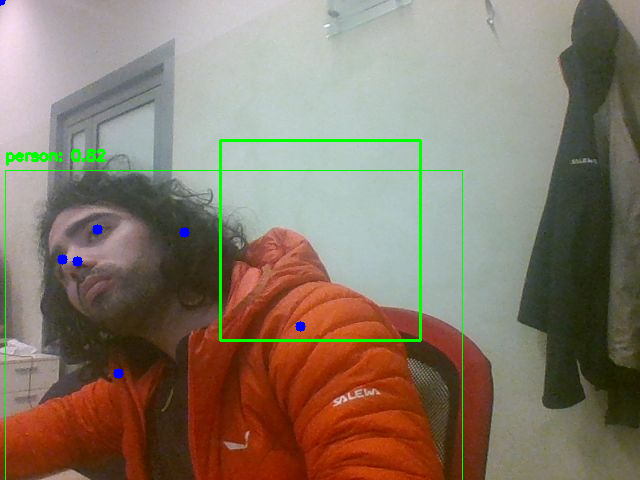

In [58]:
img_draw, [x1,y1,x2,y2] = get_rectangle_area(img)
display(img_draw)